In [4]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [ ]:
!pip install tensorflow

In [5]:
from alphavantage_service import AlphaVantageService
from entities.asset import Asset
from enums.asset_type import AssetType

### Alpha Vantage Intro
The Alpha Vantage API is a method to obtain historical and realtime data for several markets.

For reference: https://medium.com/@patrick.collins_58673/stock-api-landscape-5c6e054ee631

In [6]:

API_KEY = open("api_key.txt")
alphavantage_service_class = AlphaVantageService()

In [7]:
df1= alphavantage_service_class.retrieve_stock_daily_data(
    base_asset = Asset("EGRX", "Eagle Pharmaceuticals Inc", AssetType.CURRENCY),
    apikey=API_KEY
)


In [8]:
df2 = alphavantage_service_class.retrieve_stock_daily_data(
    base_asset = Asset("EFOI", "Energy Focus Inc", AssetType.CURRENCY),
    apikey=API_KEY
)


In [ ]:
#df3 = alphavantage_service_class.retrieve_stock_daily_data(
#    base_asset = Asset("CIS", "Camelot Information Systems", AssetType.CURRENCY),
#    apikey=API_KEY
#)

In [9]:
# stack the two DataFrames
df = pd.concat([df1, df2], ignore_index=True, axis=0)

In [10]:
df

,Date,Symbol,Close,Open,Low,High,Volume,AdjustedClose,Change
0,2014-02-12,EGRX,12.83,15.5,12.75,16.44,5.94826e+06,12.83,-0.708409
1,2014-02-13,EGRX,13.22,12.51,12.47,13.48,487358,13.22,0.0303975
2,2014-02-14,EGRX,12.8,13.2,12.76,13.59,107162,12.8,-0.03177
3,2014-02-18,EGRX,12.94,13,12.6,13.07,81656,12.94,0.0109375
4,2014-02-19,EGRX,12.14,12.71,11.74,12.95,273287,12.14,-0.0618238
...,...,...,...,...,...,...,...,...,...
4086,2022-06-08,EFOI,2.7,2.98,2.3101,3.12,4.6515e+07,2.7,1.14286
4087,2022-06-09,EFOI,2.29,2.46,2.21,2.56,5.50007e+06,2.29,1.14019
4088,2022-06-10,EFOI,2.52,2.39,2.22,2.729,4.57433e+06,2.52,1.8404
4089,2022-06-13,EFOI,2.45,2.45,2.3062,2.54,4.83945e+06,2.45,1.75963


In [11]:
# General df operations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           4091 non-null   object
 1   Symbol         4091 non-null   object
 2   Close          4091 non-null   object
 3   Open           4091 non-null   object
 4   Low            4091 non-null   object
 5   High           4091 non-null   object
 6   Volume         4091 non-null   object
 7   AdjustedClose  4091 non-null   object
 8   Change         4089 non-null   object
dtypes: object(9)
memory usage: 287.8+ KB


In [12]:
df.describe()

,Date,Symbol,Close,Open,Low,High,Volume,AdjustedClose,Change
count,4091,4091,4091.0,4091.0,4091.0,4091.0,4091.0,4091.0,4089.0
unique,2100,2,2761.0,2714.0,2936.0,2957.0,4068.0,2840.0,3987.0
top,2016-08-15,EGRX,2.2,12.5,5.0,5.0,0.0,11.0,0.0
freq,2,2100,11.0,17.0,12.0,12.0,4.0,12.0,53.0


In [13]:
df["Date"].unique().shape

(2100,)

In [14]:
df.Symbol.unique()

array(['EGRX', 'EFOI'], dtype=object)

In [15]:
stock_types = ['EGRX', 'EFOI']

## Cleaning and EDA

### Checking missing values and a first look at the data

In [16]:
# checkig for missing values
df.isnull().sum()

Date             0
Symbol           0
Close            0
Open             0
Low              0
High             0
Volume           0
AdjustedClose    0
Change           2
dtype: int64

##### Remarks: Change 1 is correct as the change for the 1st entry in my dataframe cannot be calculated. Hence I need to drop the first row

In [17]:
nan_rows= df[df["Change"].isnull()]
print(nan_rows)

            Date Symbol  Close   Open    Low   High  Volume AdjustedClose  \
1100  2018-06-26   EGRX  74.68  73.46  72.15  74.75  180334         74.68   
3091  2018-06-26   EFOI   1.94   1.97   1.94   1.97    6343           9.7   

     Change  
1100    NaN  
3091    NaN  


In [18]:
# Replace NaN with 0.0
df["Change"] = df["Change"].replace(np.nan, 0.0)

In [19]:
df.isnull().sum()

Date             0
Symbol           0
Close            0
Open             0
Low              0
High             0
Volume           0
AdjustedClose    0
Change           0
dtype: int64

In [20]:
# Checking the earliest instance for each Stock
for stock in stock_types:
    print(df[df["Symbol"] == stock].Date.min(), stock)

2014-02-12 EGRX
2014-07-21 EFOI


###### We can notice that our stocks that we are interested in, are from 2014 

In [21]:
# Statistics
for stock in stock_types:
    print(df[df["Symbol"] == stock].describe(), stock, "\n\n\n")

            Change
count  2100.000000
mean      0.032807
std       0.359272
min      -0.814917
25%      -0.021535
50%       0.000000
75%       0.022054
max       4.391489 EGRX 



            Change
count  1991.000000
mean      0.585193
std       3.522042
min      -0.973818
25%      -0.037814
50%      -0.000537
75%       0.035995
max      80.922896 EFOI 





#### The standard deviation for EFOI is higher (3.52) meaning the variance is higher!

## Visualization of variation of the prices over time!

In [25]:
fig = px.line(df, x = "Date", y = "AdjustedClose",
              color = 'Symbol',
              title = "Stock Prices over Time",
              width = 1000, height = 600)
fig.show()

##### For the Forecasting step, we need to scale each stock separately. But for purpose of variance comparison, we can scale all data together.



In [26]:
df.AdjustedClose.values

array([12.83, 13.22, 12.8, ..., 2.52, 2.45, 2.04], dtype=object)

In [27]:
scaler = MinMaxScaler()
df_adjclose_scaled = df.copy()
df_adjclose_scaled.AdjustedClose = scaler.fit_transform(df.AdjustedClose.values.reshape(-1, 1))

In [26]:
fig = px.line(df_adjclose_scaled, x = "Date", 
              y = "AdjustedClose", color = 'Symbol', 
              title = "Scaled Stock Prices over Time",
              width = 1000, height = 600)
fig.show()

From the graph it is clear that EFOI: Energy Focus Inc reached it's maximum in Sept 2015

In order to visualize a less noisy behaviour and variations let's use now moving average. To do so, we need first generate the moving averge for each stock data and then plot it.

In [27]:
fig = make_subplots(rows = 7, cols = 1,
                    subplot_titles = [f"Comparing {i} with moving average of 20 days." for i in stock_types])

for i in range(1,len(stock_types)+1):
    
    fig.add_trace(
        go.Scatter(x = df[df.Symbol == stock_types[i - 1]].Date, 
                   y = df[df.Symbol == stock_types[i - 1]].AdjustedClose,
                    mode = 'lines',
                    name = stock_types[i - 1]),
                    row = i, col = 1)

    fig.add_trace(
        go.Scatter(x = df[df.Symbol == stock_types[i - 1]].Date, 
                   y = df[df.Symbol == stock_types[i - 1]].AdjustedClose.rolling(20).mean(),
                    mode = 'lines',
                    name = stock_types[i - 1] + " MM"),
                    row = i, col = 1)

fig.update_layout(width = 1000, height = 3000)
fig.show()


From the above plot, we can see price variation for stock with less noise. We can notice a much smoother line.



## Visualization of Volumes over time


When trading the stocks, we must also understand the trading volume, the flow. A large flow signifies a certain directional movement.

In [28]:
fig = px.line(df, x = "Date", y = "Volume",
              color = 'Symbol',
              title = "Stock Volumes over Time",
              width = 1000, height = 600)
fig.show()

From the above plot we can see the volume for EFOI-Energy Focus Inc is more during 2022

## Daily Return

To measure your daily gains and measure your daily losses 

In [28]:
# Creating the Daily Return feature
return_list = []
for stock in stock_types:
    return_list.extend(df[df.Symbol == stock].AdjustedClose.pct_change())

df['daily_return'] = np.array(return_list)

In [29]:
sub_df = df[(df.daily_return > -0.3) & (df.daily_return < 0.3)] 


array([[<AxesSubplot:title={'center':'daily_return'}>]], dtype=object)

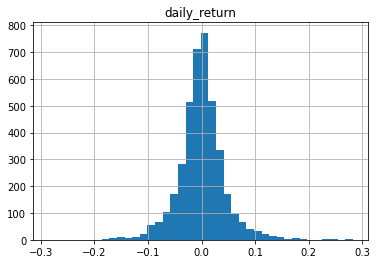

In [30]:

sub_df.hist(column='daily_return',bins=40)

From the above histogram we see that daily return is normally distributed

## Risk Analysis

In [31]:
daily_return_mean = []
daily_return_std = []
for stock in stock_types:
    daily_return_mean.append(df[df.Symbol == stock].daily_return.mean())
    daily_return_std.append(df[df.Symbol == stock].daily_return.std())
    
    
fig = go.Figure()
fig.add_trace(go.Scatter(x = daily_return_mean,
                  y = daily_return_std,
                  mode = "markers+text",
                  marker = dict(size = 10),
                  text = stock_types,
                  textposition='top center'))


fig.update_layout(width = 1000, height=500,
                  title_text='Risk and Expected return for each company')
fig.update_xaxes(title_text = "Expected Return")
fig.update_yaxes(title_text = "Risk")

fig.show()


From the above plot we can see, EGRX has most expected returns and less risk while EFOI has greater risk with least returns

## Correlations

In [32]:
pears_corr = df.corr(method= "pearson")

Since I took only three stocks, Correlation would not make much sense to apply and correlation cannot predict values

In [33]:
fig = go.Figure(
    go.Heatmap(x = stock_types, y = stock_types, 
               z = pears_corr.values,
               colorscale = 'blues')
    )
fig.update_layout(title = "Companies Adjusted Close Price Correlation",
                  width = 1000, height = 600)
fig.show()

## Data Preparation

In [34]:
scaler = MinMaxScaler()
index = df[df.Symbol == "EGRX"].index
df.loc[index, "AdjustedClose"] = scaler.fit_transform(df.loc[index].AdjustedClose.values.reshape(-1, 1))
df.loc[index]


,Date,Symbol,Close,Open,Low,High,Volume,AdjustedClose,Change,daily_return
0,2014-02-12,EGRX,12.83,15.5,12.75,16.44,5.94826e+06,0.0385753,-0.708409,NaN
1,2014-02-13,EGRX,13.22,12.51,12.47,13.48,487358,0.0428493,0.030398,0.030398
2,2014-02-14,EGRX,12.8,13.2,12.76,13.59,107162,0.0382466,-0.031770,-0.031770
3,2014-02-18,EGRX,12.94,13,12.6,13.07,81656,0.0397808,0.010937,0.010937
4,2014-02-19,EGRX,12.14,12.71,11.74,12.95,273287,0.0310137,-0.061824,-0.061824
...,...,...,...,...,...,...,...,...,...,...
2095,2022-06-08,EGRX,45.82,47,45.5,47.07,130954,0.40011,-0.066422,-0.033333
2096,2022-06-09,EGRX,44.74,46,44.62,46.635,147534,0.388274,0.003364,-0.023570
2097,2022-06-10,EGRX,44.16,44.03,43.37,44.43,96602,0.381918,-0.022360,-0.012964
2098,2022-06-13,EGRX,42.34,43.32,41.85,43.46,130922,0.361973,-0.093362,-0.041214


In [36]:
df.shape

(4089, 10)

In [ ]:
# Convert to datetime type

In [35]:
df['Date']= pd.to_datetime(df["Date"]).dt.date

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           4091 non-null   object 
 1   Symbol         4091 non-null   object 
 2   Close          4091 non-null   object 
 3   Open           4091 non-null   object 
 4   Low            4091 non-null   object 
 5   High           4091 non-null   object 
 6   Volume         4091 non-null   object 
 7   AdjustedClose  4091 non-null   object 
 8   Change         4091 non-null   float64
 9   daily_return   4089 non-null   float64
dtypes: float64(2), object(8)
memory usage: 319.7+ KB


In [37]:
# Spliting the data into train and test
def split_data(df, company_list, prediction_length, startdate = '2014-07-21'):
    """
        Receive a dataframe with one company or more, as well as a company list and split the data into train and test 
        by the date given as input for each company.
        
        Inputs:
        - df: a dataframe containing at least timestamps and the target columns
        - company_list: a list of company present in the df. They will be splited and formated
        - prediction length: the number of timestamps that should be seprated as test data
        - start_date: is the start of our dataset. Default is the startdate for ERGX
        
        Returns:
        2 dictionaries containing the train and test datasets for each company. The datasets contain just
        the date column as well as the adjclose (target) column.
    """
    startdate = datetime.datetime.strptime(startdate, '%Y-%m-%d').date()
    print( type(df.Date))
    train = {}
    test = {} 
    list_of_features= ["Date","AdjustedClose"]
    for company in company_list:
        train[company] = df[(df.Symbol == company) & (df.Date > startdate)][:-prediction_length][list_of_features]
        test[company] = df[(df.Symbol == company) & (df.Date > startdate)][-prediction_length:][list_of_features]

    return train, test

In [38]:
# Defining the timespan to make it efficient and easier for the future
timespan = 28

# Spliting the data
train, test = split_data(df, stock_types, timespan)

<class 'pandas.core.series.Series'>


In [39]:
train

{'EGRX':             Date AdjustedClose
 110   2014-07-22     0.0412055
 111   2014-07-23     0.0361644
 112   2014-07-24     0.0339726
 113   2014-07-25     0.0367123
 114   2014-07-28     0.0360548
 ...          ...           ...
 2067  2022-04-28      0.377315
 2068  2022-04-29      0.381589
 2069  2022-05-02       0.38663
 2070  2022-05-03      0.395178
 2071  2022-05-04      0.407452
 
 [1962 rows x 2 columns],
 'EFOI':             Date AdjustedClose
 2101  2014-07-22         24.75
 2102  2014-07-23            25
 2103  2014-07-24         25.25
 2104  2014-07-25         25.25
 2105  2014-07-28            25
 ...          ...           ...
 4058  2022-04-28          1.13
 4059  2022-04-29          1.12
 4060  2022-05-02          1.07
 4061  2022-05-03          1.13
 4062  2022-05-04        1.1199
 
 [1962 rows x 2 columns]}

In [54]:
# Saving the train and test data on data folder
for stock in stock_types:
    train[stock].to_csv("./data/train_{}.csv".format(stock[:4].lower()), index = False)
    test[stock].to_csv("./data/test_{}.csv".format(stock[:4].lower()), index = False)

## AWS Sagemaker configurations

In [41]:
# Importing general aws session configuration
import boto3
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()
print(role)
bucket = session.default_bucket()
print(bucket)

arn:aws:iam::835126991641:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
sagemaker-us-east-1-835126991641


In [42]:
# Creating specific configuration
prefix = "stock-pred-capstone-project"
data_dir = "./data"
paths = {}

# Addressing the data on the disc
train_key = os.path.join(data_dir, "train_{}.csv".format("efoi"))
test_key = os.path.join(data_dir, "test_{}.csv".format("efoi"))

# Path where the files will be saved
train_prefix = "{}/{}".format(prefix, "train_{}".format("efoi"))
test_prefix = "{}/{}".format(prefix, "test_{}".format("efoi"))

# Uploading to S3
paths["train"] = session.upload_data(train_key, bucket = bucket, key_prefix = train_prefix)
paths["test"] = session.upload_data(test_key, bucket = bucket, key_prefix = test_prefix)

In [43]:
paths["train"], paths["test"] 

('s3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/train_efoi/train_efoi.csv',
 's3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/test_efoi/test_efoi.csv')

## Model Building

We are building 3 models and compare their performance in predicting stock prices. The timespan that we are interested in is 1 month (4 weeks) and as mentioned before, for each model we are going to compare RMSE and MAE. We will also visualize the quality of the predictions by using a line graph with the prediction and real values for the last 28 days.
Since this task is about continous time values(floats), we go for regression. To begin with the type of model, I am chosing Random Forest

Three features will be created
1. Differentiation of the next row
2. Lag from the original target
3. Moving Average

In [44]:
from sklearn.ensemble import RandomForestRegressor
# for feature engineering process, I am concatenating the train and test data
df_rf = pd.concat([train["EFOI"], test["EFOI"]])
df_rf.index = df_rf.Date
df_rf = df_rf.drop("Date", axis = 1)
df_rf.head()

,AdjustedClose
Date,
2014-07-22,24.75
2014-07-23,25
2014-07-24,25.25
2014-07-25,25.25
2014-07-28,25


Develop the features

In [45]:
# 1. Applying the diff to the data
df_rf["adj_close_diff"] = df_rf.diff()

# 2.Creating 10 lags for starting
for i in range (5, 0, -1):
    df_rf['t-' + str(i)] = df_rf["AdjustedClose"].shift(i)

# 3. Moving Avg of 2 weeks
df_rf["moving_avg"] = df_rf["AdjustedClose"].rolling(window = 14).mean()
    
df_rf.dropna(inplace = True)
df_rf.head()

,AdjustedClose,adj_close_diff,t-5,t-4,t-3,t-2,t-1,moving_avg
Date,,,,,,,,
2014-08-08,23.25,2,25,25,25,25,21.25,24.439286
2014-08-11,22.9995,-0.2505,25,25,25,21.25,23.25,24.314250
2014-08-12,23.5,0.5005,25,25,21.25,23.25,22.9995,24.207107
2014-08-13,23,-0.5,25,21.25,23.25,22.9995,23.5,24.046393
2014-08-14,22.7505,-0.2495,21.25,23.25,22.9995,23.5,23,23.867857


We got a dataframe to work with which can be fed as input to the random forest regressor. But first, let's split the data into train and test.

In [46]:
X_train_rf = df_rf.iloc[:-timespan].drop("AdjustedClose", axis = 1)
y_train_rf = df_rf.iloc[:-timespan]["AdjustedClose"]

X_test_rf = df_rf.iloc[-timespan:].drop("AdjustedClose", axis = 1)
y_test_rf = df_rf.iloc[-timespan:]["AdjustedClose"]

In [47]:
X_train_rf.shape, X_test_rf.shape, y_train_rf.shape, y_test_rf.shape

((1949, 7), (28, 7), (1949,), (28,))

In [48]:
# Instantiating a Regressor
regressor_rf = RandomForestRegressor(n_estimators = 1000)

# Training
regressor_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=1000)

In [49]:
#Prediction
prediction_rf = regressor_rf.predict(X_test_rf)

In [50]:
#Now that we have the predictions, let's transform it back to its non-scaled form.
prediction_rf = scaler.inverse_transform(prediction_rf.reshape(1, -1))
y_test_rf = scaler.inverse_transform(y_test_rf.values.reshape(1, -1))



In [51]:
#RMSE
np.sqrt(mean_squared_error(y_test_rf, prediction_rf))

21.655932455957284

In [52]:
# MAE
mean_absolute_error(y_test_rf, prediction_rf)

18.509239669419905

let's visualize the behaviour in line graph

In [53]:
trace_1 = go.Scatter(x = X_test_rf.index, y = y_test_rf[0],
                   mode = 'lines',
                   name = 'Real Price')

trace_2 = go.Scatter(x = X_test_rf.index, y = prediction_rf[0],
                    mode = "lines",
                    name = "Predicted Price")

layout = go.Layout(title = "Real Price vs Predicted Price using Random Forest Regressor",
                   width = 1000, height = 600)

fig = go.Figure(data = [trace_1, trace_2], layout = layout)
fig.show()

From the above visualization we see how good the model was predicting the stock price behaviour of EFOI stock. That is a great guidence for making investments in along 2022.

## DeepAR algorithm approach

Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks. As per the DeepAR documentation, the input training data should be of JSON format with fields:


1.start: starting date of the time series. Type: string and format 'YYYY-MM-DD HH:MM:SS'

2.target: array of numerical values that represent the time series.

3.cat (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.
The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:

{"start":'2014-03-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}

{"start": "2014-03-31 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]}

In [56]:
# Converting the data
def convert_to_json(df):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(df["Date"].min().strftime("%Y-%m-%d") + " 00:00:00"), 
                "target": list(df["AdjustedClose"])}
    return json_obj

In [57]:
def save_json_dataset(df, filename):
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        #for ts in df:
        json_line = json.dumps(convert_to_json(df)) + '\n'
        json_line = json_line.encode('utf-8')
        f.write(json_line)
    print(filename + ' saved.')

In [58]:

save_json_dataset(train["EFOI"], "./data/train_efoi.json")
save_json_dataset(test["EFOI"], "./data/test_efoi.json")

./data/train_efoi.json saved.
./data/test_efoi.json saved.


 Upload JSON data to S3

In [59]:
train_json_key = os.path.join(data_dir, "train_efoi.json")
test_json_key = os.path.join(data_dir, "test_efoi.json")

train_json_prefix = "{}/{}".format(prefix, "train_efoi_json")
test_json_prefix = "{}/{}".format(prefix, "test_efoi_json")

path_train_efoi_json = session.upload_data(train_json_key, 
                                           bucket = bucket, 
                                           key_prefix = train_json_prefix)

path_test_efoi_json = session.upload_data(test_json_key, 
                                          bucket = bucket, 
                                          key_prefix = test_json_prefix)

In [ ]:
#path_train_efoi_json = 's3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/train_efoi_json/train_efoi.json'

In [ ]:
#path_test_efoi_json= 's3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/test_efoi_json/test_efoi.json'

In [68]:
# Getting the image uri that points to the DeepAR container for this region.
from sagemaker import image_uris

deepar_image = image_uris.retrieve("forecasting-deepar", region = boto3.Session().region_name)

In [66]:
# Setting up the output path
output_path = "s3://{}/{}/output".format(bucket, prefix)

# Instantiating the model
deepar_estimator_model = sagemaker.estimator.Estimator(image_uri = deepar_image,
                                                 role = role,
                                                 instance_count = 1,
                                                 #model_uri = "s3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/output/forecasting-deepar-2022-06-14-21-03-06-848/output/",
                                                 instance_type = "ml.c4.4xlarge",
                                                 output_path = output_path,
                                                 sagemaker_session = session)

In [69]:
timespan

28

In [70]:
# Hyperparameters configuration
freq = 'D'
prediction_length = timespan # Four weeks
context_length = train["EFOI"].shape[0] - prediction_length

hyperparameters = {
    "epochs": str(50),
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [71]:
deepar_estimator_model.set_hyperparameters(**hyperparameters)

Training the model. By default, model uses the RMSE as the performance metric.

In [72]:
%%time
# train and test channels
data_channels = {
    "train": path_train_efoi_json,
    "test": path_test_efoi_json}


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [73]:
%%time
# fit the estimator
deepar_estimator_model.fit(inputs=data_channels)

2022-06-15 06:56:28 Starting - Starting the training job...
2022-06-15 06:56:54 Starting - Preparing the instances for trainingProfilerReport-1655276188: InProgress
......
2022-06-15 06:57:56 Downloading - Downloading input data...
2022-06-15 06:58:17 Training - Downloading the training image.....Arguments: train
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/15/2022 06:59:12 INFO 139795572078400] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': '

Create a Predictor

In [74]:
%%time

from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


# create a predictor
predictor_deepar = deepar_estimator_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=JSONSerializer(),
    deserializer= JSONDeserializer()
)

-------!CPU times: user 129 ms, sys: 8.72 ms, total: 137 ms
Wall time: 3min 31s


In [75]:
#Create test JSON for predicition
test_json = {
    "instances": [{"start": str(test["EFOI"].Date.values[0]) + " 00:00:00",
                  "target": []}],
    "configuration": {
        "num_samples":10,
        "output_types": ["mean"]
    }}

In [76]:
prediction_response_deepar = predictor_deepar.predict(test_json)

In [77]:
# Rescaling the result
prediction_response_deepar = scaler.inverse_transform(np.array(prediction_response_deepar["predictions"][0]["mean"]).reshape(1,-1))

In [78]:
# RMSE
np.sqrt(mean_squared_error(y_test_rf, prediction_response_deepar))

812.3742729931464

In [79]:
# MAE
mean_absolute_error(y_test_rf, prediction_response_deepar)

794.7227111970805

In [80]:
prediction_response_deepar[0]

array([ 289.15585881,  550.35669512,  641.79531699,  775.27460104,
        744.28613669,  791.32978207,  823.69355446,  874.4904924 ,
        845.2502287 ,  879.93324524,  871.90652495,  935.79229837,
        945.65937644,  955.5256713 ,  966.12147814,  986.65859347,
        969.52023989,  999.24217468, 1033.20934182, 1058.43820339,
       1063.84780055, 1061.67666917, 1069.30621749, 1061.29446513,
       1094.59068661, 1123.89317161, 1185.94137197, 1190.51868325])

The values of the metrics for DeepAR-Forecasting are RMSE of 843.15 and a MAE of 832.84 . MAE < RMSE

So, let's visualize this behaviour in a line graph.

In [81]:

trace1 = go.Scatter(x = X_test_rf.index, y = y_test_rf[0],
                   mode = 'lines',
                   name = 'Real Price')

trace2 = go.Scatter(x = X_test_rf.index, y = prediction_response_deepar[0],
                    mode = "lines",
                    name = "Predicted Price")

layout = go.Layout(title = "Real Price vs Predicted Price using AWS DeepAR-Forecasting for EFOI stock",
                   width = 1000, height = 600)

fig = go.Figure(data = [trace1, trace2], layout = layout)
fig.show()

## LSTM approach (optional)

As I already explored AWS and Sagemaker and the purpose of Capstone project is already met, I am considering LSTM approach as an optional model training method

In [83]:
!pip install tensorflow-gpu

In [84]:
!pip install -U sagemaker

In [85]:
from sagemaker.tensorflow import TensorFlow
# Setting up the output path

output_path = f"s3://{bucket}/{prefix}/output"

tf_estimator = TensorFlow(
    entry_point='train.py',
    # source_dir='s3://sagemaker-us-east-1-835126991641/source/', 
    role=role,
    framework_version='2.3.0',
    model_dir = False,
    py_version='py37',
    instance_type='ml.c4.xlarge',
    instance_count=1,
    output_path=output_path,
    hyperparameters={
        'batch-size':32,
        'epochs':100
    }
)

In [86]:
paths = {
    'train': 's3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/train_efoi/train_efoi.csv',
     'test': 's3://sagemaker-us-east-1-835126991641/stock-pred-capstone-project/test_efoi/test_efoi.csv'
}

In [87]:
%%time
tf_estimator.fit(paths["train"])

2022-06-15 08:05:47 Starting - Starting the training job...
2022-06-15 08:06:17 Starting - Preparing the instances for trainingProfilerReport-1655280347: InProgress
.........
2022-06-15 08:07:38 Downloading - Downloading input data...
2022-06-15 08:07:59 Training - Downloading the training image...
2022-06-15 08:08:39 Training - Training image download completed. Training in progress..2022-06-15 08:08:47,315 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-06-15 08:08:47,321 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-15 08:09:42,133 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-15 08:09:42,150 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-15 08:09:42,166 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-15 08:09:42,181 sagemaker-training-toolkit INFO     Invok

In [91]:
predictor_tf = tf_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


--------!

In [92]:
train_input_tf = train["EFOI"].AdjustedClose.values.reshape(-1,1)
test_input_tf = test["EFOI"].AdjustedClose.values.reshape(-1,1)

In [93]:
df_volume = np.vstack((train_input_tf, test_input_tf))
window = 30 # number of lags

inputs = df_volume[df_volume.shape[0] - test_input_tf.shape[0] - window:]
inputs = inputs.reshape(-1, 1)

prediction_length = df_volume.shape[0] - train_input_tf.shape[0] + window

X_test = []

for i in range(window, prediction_length):
    X_test_reshaped = np.reshape(inputs[i-window:i], (window, 1))
    X_test.append(X_test_reshaped)

X_test = np.stack(X_test)

In [94]:
# Making predictions
prediction_tf = np.array(predictor_tf.predict(X_test)["predictions"])
# Scaling the predictions back
prediction_tf = scaler.inverse_transform(prediction_tf).flatten()

In [95]:
# RMSE
np.sqrt(mean_squared_error(y_test_rf[0], prediction_tf))

35.98814797192305

In [96]:
# MAE
mean_absolute_error(y_test_rf[0], prediction_tf)

22.54258729714286

In [97]:
trace_1 = go.Scatter(x = X_test_rf.index, y = y_test_rf[0],
                   mode = 'lines',
                   name = 'Real Price')

trace_2 = go.Scatter(x = X_test_rf.index, y = prediction_tf,
                   mode = "lines",
                   name = "Predicted Price")

layout = go.Layout(title = "Real Price vs Predicted Price using LSTM with Tensor Flow",
                   width = 1000, height = 600)

fig = go.Figure(data = [trace_1, trace_2], layout = layout)
fig.show()

In [103]:
import pandas as pd
metrics = {"RMSE": [21.65, 812.37,35.988], "MAE": [18.50, 794.722, 22.542]}
pd.DataFrame(metrics, index = ["Random Forest", "DeepAR", "LSTM"] )


,RMSE,MAE
Random Forest,21.650,18.500
DeepAR,812.370,794.722
LSTM,35.988,22.542


In [104]:
trace_1 = go.Scatter(
    x = X_test_rf.index, 
    y = y_test_rf[0],
    mode = 'lines',
    name = 'Real Price'
)

trace_2 = go.Scatter(
    x = X_test_rf.index, 
    y = prediction_rf[0],
    mode = "lines",
    name = "Predicted Price with Random Forest Regressor"
)

trace_3 = go.Scatter(
    x = X_test_rf.index, 
    y = prediction_response_deepar[0],
    mode = "lines",
    name = "Predicted Price DeepAR"
)

trace_4 = go.Scatter(
    x = X_test_rf.index, 
    y = prediction_tf,
    mode = "lines",
    name = "Predicted Price LSTM"
)

layout = go.Layout(
    title = "Comparing the Results of Models with the Real Price",
    width = 1000, 
    height = 600
)

fig = go.Figure(data = [trace_1, trace_2, trace_3,trace_4], layout = layout)
fig.show()

## Conclusion

The DeepAR deviates from the Real Price. It is not a ideal way of modelling . Random Forest worked better in prediction.

Further Steps:
More scope to experiment on this financial data. 
- Make use of SageMaker Hyperparameters Tunning to improve the the LSTM model.
- Try a model based on Convulational Networks. CNNs work better on time-series data
